In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [116]:
def getDarkChannel(src, patchSize=(15,15)):
    b,g,r = cv2.split(src)
    h,w,c = src.shape
    darkB = np.zeros((h,w))
    darkG = np.zeros((h,w))
    darkR = np.zeros((h,w))
    marginI = (patchSize[1]-1) // 2
    marginJ = (patchSize[0]-1) // 2
    for i in(range(h)):
        preMarginI = i-marginI if((i-marginI) >= 0) else 0
        postMarginI = i+marginI if((i+marginI) <= h) else h
        for j in(range(w)):
            preMarginJ = j-marginJ if((j-marginJ) >= 0) else 0
            postMarginJ = j+marginJ if((j+marginJ) <= w) else w
            darkB[i,j] = np.min(b[preMarginI:postMarginI,preMarginJ:postMarginJ])
            darkG[i,j] = np.min(g[preMarginI:postMarginI,preMarginJ:postMarginJ])
            darkR[i,j] = np.min(r[preMarginI:postMarginI,preMarginJ:postMarginJ])
    return(darkB,darkG,darkR)

def getImgIntensityFromRgb(src):
    b,g,r = cv2.split(src.astype(int))
    return b + g + r

def getAtmosphericLight(src, darkChannel, candidateRatio=0.01):
    dcf = np.sort(np.array(darkChannel).flatten())[::-1]
    threshold = dcf[int(len(dcf) * candidateRatio)]
    imageIntensity = getImgIntensityFromRgb(src)
    atmosphericIntensityThreshold = max(imageIntensity[darkChannel > threshold])
    return src[np.logical_and((imageIntensity >= atmosphericIntensityThreshold),(darkChannel > threshold))][0]
   
def getTransmision(src, A, patchSize=(15,15), W=0.95):
    return 1 - W * np.min(getDarkChannel(src / A),axis=0)

def recoverSceneRadiance(src,t,A,t0=0.1):
    h,w,c = src.shape
    t0 = np.ones((h,w)) * t0
    A = np.ones((h,w,1)) * A
    
    r = src - A
    r[:,:,0] = r[:,:,0] / np.maximum(t,t0)
    r[:,:,1] = r[:,:,1] / np.maximum(t,t0)
    r[:,:,2] = r[:,:,2] / np.maximum(t,t0)
    res = (r + A).astype(np.int8)
    res[res > 255] = 255
    return res.astype(np.uint8)

In [106]:
from itertools import combinations_with_replacement
from collections import defaultdict

import numpy as np
from numpy.linalg import inv

R, G, B = 0, 1, 2  # index for convenience


def boxfilter(I, r):
    """Fast box filter implementation.
    Parameters
    ----------
    I:  a single channel/gray image data normalized to [0.0, 1.0]
    r:  window radius
    Return
    -----------
    The filtered image data.
    """
    M, N = I.shape
    dest = np.zeros((M, N))

    # cumulative sum over Y axis
    sumY = np.cumsum(I, axis=0)
    # difference over Y axis
    dest[:r + 1] = sumY[r: 2 * r + 1]
    dest[r + 1:M - r] = sumY[2 * r + 1:] - sumY[:M - 2 * r - 1]
    dest[-r:] = np.tile(sumY[-1], (r, 1)) - sumY[M - 2 * r - 1:M - r - 1]

    # cumulative sum over X axis
    sumX = np.cumsum(dest, axis=1)
    # difference over Y axis
    dest[:, :r + 1] = sumX[:, r:2 * r + 1]
    dest[:, r + 1:N - r] = sumX[:, 2 * r + 1:] - sumX[:, :N - 2 * r - 1]
    dest[:, -r:] = np.tile(sumX[:, -1][:, None], (1, r)) - \
        sumX[:, N - 2 * r - 1:N - r - 1]

    return dest


def guided_filter(I, p, r=40, eps=1e-3):
    """Refine a filter under the guidance of another (RGB) image.
    Parameters
    -----------
    I:   an M * N * 3 RGB image for guidance.
    p:   the M * N filter to be guided
    r:   the radius of the guidance
    eps: epsilon for the guided filter
    Return
    -----------
    The guided filter.
    """
    M, N = p.shape
    base = boxfilter(np.ones((M, N)), r)

    # each channel of I filtered with the mean filter
    means = [boxfilter(I[:, :, i], r) / base for i in range(3)]
    # p filtered with the mean filter
    mean_p = boxfilter(p, r) / base
    # filter I with p then filter it with the mean filter
    means_IP = [boxfilter(I[:, :, i] * p, r) / base for i in range(3)]
    # covariance of (I, p) in each local patch
    covIP = [means_IP[i] - means[i] * mean_p for i in range(3)]

    # variance of I in each local patch: the matrix Sigma in ECCV10 eq.14
    var = defaultdict(dict)
    for i, j in combinations_with_replacement(range(3), 2):
        var[i][j] = boxfilter(
            I[:, :, i] * I[:, :, j], r) / base - means[i] * means[j]

    a = np.zeros((M, N, 3))
    for y, x in np.ndindex(M, N):
        #         rr, rg, rb
        # Sigma = rg, gg, gb
        #         rb, gb, bb
        Sigma = np.array([[var[R][R][y, x], var[R][G][y, x], var[R][B][y, x]],
                          [var[R][G][y, x], var[G][G][y, x], var[G][B][y, x]],
                          [var[R][B][y, x], var[G][B][y, x], var[B][B][y, x]]])
        cov = np.array([c[y, x] for c in covIP])
        a[y, x] = np.dot(cov, inv(Sigma + eps * np.eye(3)))  # eq 14

    # ECCV10 eq.15
    b = mean_p - a[:, :, R] * means[R] - \
        a[:, :, G] * means[G] - a[:, :, B] * means[B]

    # ECCV10 eq.16
    q = (boxfilter(a[:, :, R], r) * I[:, :, R] + boxfilter(a[:, :, G], r) *
         I[:, :, G] + boxfilter(a[:, :, B], r) * I[:, :, B] + boxfilter(b, r)) / base

    return q

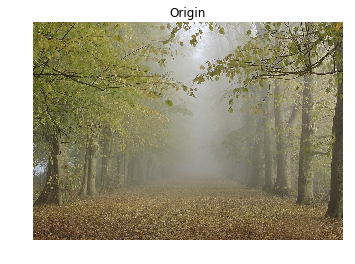

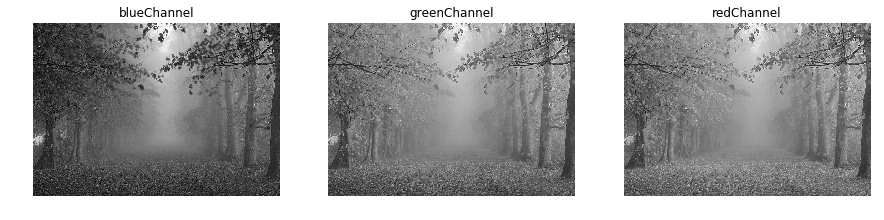

In [149]:
src = np.array(cv2.imread('.img/forest1.jpg'))
plt.title('Origin')
plt.imshow(cv2.cvtColor(src, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

plt.subplots(figsize=(15, 8))
for i,c in enumerate(cv2.split(src)):
    plt.subplot(1,3,i + 1)
    plt.title('{}'.format(['blueChannel','greenChannel','redChannel'][i]))
    plt.imshow(c,cmap='gray')
    plt.axis('off')
plt.show()

In [142]:
darkChannels = getDarkChannel(src,patchSize=(15,15))

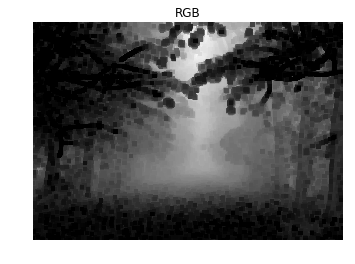

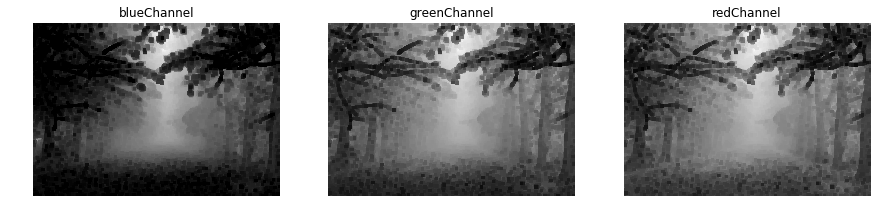

In [143]:
# dark channel
plt.title('RGB')
plt.imshow(np.min(darkChannels,axis=0),cmap='gray')
plt.axis('off')
plt.show()

plt.subplots(figsize=(15, 8))
for i,c in enumerate(darkChannels):
    plt.subplot(1,3,i + 1)
    plt.title('{}'.format(['blueChannel','greenChannel','redChannel'][i]))
    plt.imshow(c,cmap='gray')
    plt.axis('off')
plt.show()

In [144]:
# recover
A = getAtmosphericLight(src, np.min(darkChannels,axis=0))
t = getTransmision(src, A)
normSrc = (src - src.min()) / (src.max() - src.min())  # normalize src
tr = guided_filter(normSrc, t)
res = recoverSceneRadiance(src,tr,A)

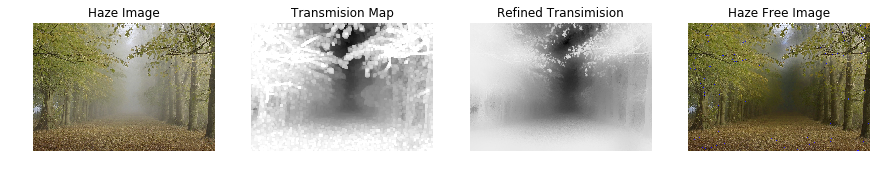

In [145]:
plt.subplots(figsize=(15, 8))

plt.subplot(1,4,1)
plt.title('Haze Image')
plt.imshow(cv2.cvtColor(src, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1,4,2)
plt.title('Transmision Map')
plt.imshow(t,cmap='gray')
plt.axis('off')

plt.subplot(1,4,3)
plt.title('Refined Transimision')
plt.imshow(tr,cmap='gray')
plt.axis('off')

plt.subplot(1,4,4)
plt.title('Haze Free Image')
plt.imshow(cv2.cvtColor(res, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.show()

In [150]:
#cv2.imwrite("forest_dcr_li.png",res)